In [26]:
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
# Define the image size
IMAGE_SIZE = (331, 331)  # PNASNetLarge requires input size (331, 331)


In [13]:
# Set the paths to the training and validation data
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [15]:
# Replace this line with the path to the downloaded NASNetLarge model weights on your local machine
weights_path = '/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Pneumonia_models/NASNet-large-no-top.h5'



# Load the NASNetLarge model with local weights file
pnasnet = NASNetLarge(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights=None)

# Load the downloaded weights
pnasnet.load_weights(weights_path)


In [16]:
# Freeze all layers in the PNASNet model
for layer in pnasnet.layers:
    layer.trainable = False

In [17]:
# Get the folders in the training data directory
folders = glob('chest_xray/train/*')


In [18]:
# Add a flatten layer and a dense layer to the PNASNet model
x = Flatten()(pnasnet.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [19]:
# Create a model object
model = Model(inputs=pnasnet.input, outputs=prediction)

In [20]:
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 331, 331, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 165, 165, 96)         2592      ['input_5[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 165, 165, 96)         384       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation_1040 (Activatio  (None, 165, 165, 96)         0         ['stem_bn1[0][0]']        

In [21]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [22]:
# Create image data generators for the training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Generate training and validation data
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=10,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size=IMAGE_SIZE,
                                            batch_size=10,
                                            class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
# Train the model
model.fit(
    training_set,
    validation_data=test_set,
    epochs=1,
)


522/522 [==============================] - 1671s 3s/step - loss: 4.6361 - accuracy: 0.9183 - val_loss: 15.6251 - val_accuracy: 0.8478


In [28]:
# Load and preprocess an image for prediction
img = image.load_img('chest_xray/test/Normal/IM-0001-0001.jpeg', target_size=(331, 331))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
result = int(classes[0][0])

if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")


1/1 [==============================] - 5s 5s/step
Person is Affected By PNEUMONIA


In [29]:
# Initialize an empty list to store true and predicted labels
true_labels = []
predicted_labels = []

In [30]:
# Loop through the test set and predict labels
for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)

    # Convert one-hot encoded labels to class labels
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 1s 997ms/step


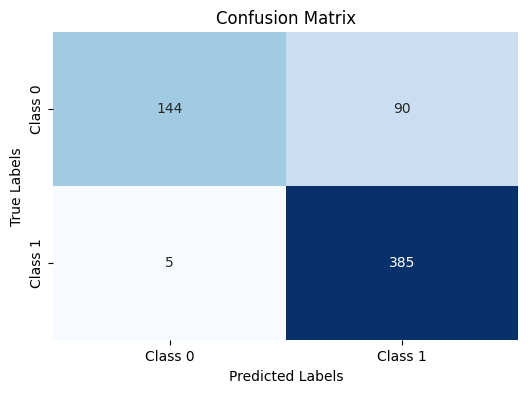

In [31]:
# Calculate the confusion matrix, accuracy, precision, recall, and F1-score
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.show()

In [32]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy   :", accuracy)
precision = precision_score(true_labels, predicted_labels)
print("Precision :", precision)
recall = recall_score(true_labels, predicted_labels)
print("Recall    :", recall)
F1_score = f1_score(true_labels, predicted_labels)
print("F1-score  :", F1_score)

Accuracy   : 0.8477564102564102
Precision : 0.8105263157894737
Recall    : 0.9871794871794872
F1-score  : 0.8901734104046243
